# Recurrent Neural Network

### Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
plt.style.use("ggplot")

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

Using TensorFlow backend.


### Data Loading

In [2]:
df = pd.read_csv("BTC-USD.csv")

## Data Preprocess

In [3]:
#  Setting the datetime index as the date, only selecting the 'Close' column, then only the last 1000 closing prices.
df = df.set_index("Date")[['Close']].tail(1000)
df = df.set_index(pd.to_datetime(df.index))

# Normalizing/Scaling the Data
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

In [4]:
# Checking the newly formatted DataFrame
df.head()

,Close
Date,
2017-06-23,0.046397
2017-06-24,0.038645
2017-06-25,0.037546
2017-06-26,0.031230
2017-06-27,0.035442


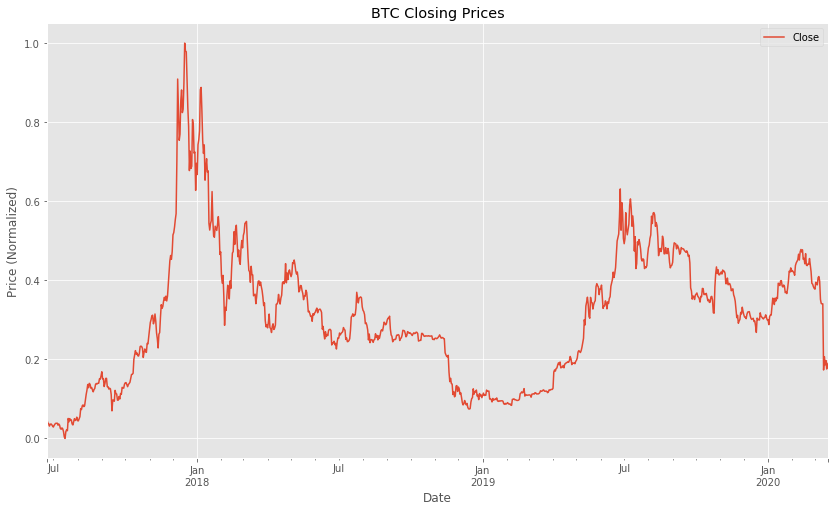

In [5]:
# Plotting the Closing Prices
df.plot(figsize=(14,8))
plt.title("BTC Closing Prices")
plt.ylabel("Price (Normalized)")
plt.show()

## Functions to prepare the data for LTSM

In [6]:
def split_sequence(seq, n_steps_in, n_steps_out):
    """
    Splits the univariate time sequence
    """
    X, y = [], []
    
    for i in range(len(seq)):
        end = i + n_steps_in
        out_end = end + n_steps_out
        
        if out_end > len(seq):
            break
        
        seq_x, seq_y = seq[i:end], seq[end:out_end]
        
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)

In [7]:
def visualize_training_results(results):
    """
    Plots the loss and accuracy for the training and testing data
    """
    history = results.history
    plt.figure(figsize=(12,4))
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure(figsize=(12,4))
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

In [8]:
def layer_maker(n_layers, n_nodes, activation, drop=None, d_rate=.5):
    """
    Creates a specified number of hidden layers for an RNN
    Optional: Adds regularization option - the dropout layer to prevent potential overfitting (if necessary)
    """
    
    # Creating the specified number of hidden layers with the specified number of nodes
    for x in range(1,n_layers+1):
        model.add(LSTM(n_nodes, activation=activation, return_sequences=True))

        # Adds a Dropout layer after every Nth hidden layer (the 'drop' variable)
        try:
            if x % drop == 0:
                model.add(Dropout(d_rate))
        except:
            pass

## Splitting the Data

In [9]:
# How many periods looking back to learn
n_per_in  = 30

# How many periods to predict
n_per_out = 10

# Features (in this case it's 1 because there is only one feature: price)
n_features = 1

# Splitting the data into appropriate sequences
X, y = split_sequence(list(df.Close), n_per_in, n_per_out)

# Reshaping the X variable from 2D to 3D
X = X.reshape((X.shape[0], X.shape[1], n_features))

## Modeling - LSTM (RNN)

### Creating the Neural Network

In [10]:
# Instatiating the model
model = Sequential()

# Activation
activ = "softsign"

# Input layer
model.add(LSTM(30, activation=activ, return_sequences=True, input_shape=(n_per_in, n_features)))

# Hidden layers
layer_maker(n_layers=6, n_nodes=12, activation=activ)

# Final Hidden layer
model.add(LSTM(10, activation=activ))

# Output layer
model.add(Dense(n_per_out))

# Model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 30)            3840      
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 12)            2064      
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 12)            1200      
_________________________________________________________________
lstm_4 (LSTM)                (None, 30, 12)            1200      
_________________________________________________________________
lstm_5 (LSTM)                (None, 30, 12)            1200      
_________________________________________________________________
lstm_6 (LSTM)                (None, 30, 12)            1200      
_________________________________________________________________
lstm_7 (LSTM)                (None, 30, 12)           

In [11]:
# Compiling the data with selected specifications
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

### Fitting and Training the RNN

In [12]:
res = model.fit(X, y, epochs=800, batch_size=32, validation_split=0.1)

Train on 864 samples, validate on 97 samples
Epoch 1/800
864/864 [==============================] - 6s 7ms/step - loss: 0.0965 - accuracy: 0.0845 - val_loss: 0.0664 - val_accuracy: 0.0825
Epoch 2/800
864/864 [==============================] - 2s 3ms/step - loss: 0.0499 - accuracy: 0.1053 - val_loss: 0.0201 - val_accuracy: 0.0825
Epoch 3/800
864/864 [==============================] - 2s 3ms/step - loss: 0.0352 - accuracy: 0.1053 - val_loss: 0.0105 - val_accuracy: 0.0825
Epoch 4/800
864/864 [==============================] - 2s 3ms/step - loss: 0.0307 - accuracy: 0.1053 - val_loss: 0.0083 - val_accuracy: 0.0825
Epoch 5/800
864/864 [==============================] - 2s 2ms/step - loss: 0.0294 - accuracy: 0.1053 - val_loss: 0.0079 - val_accuracy: 0.0825
Epoch 6/800
864/864 [==============================] - 2s 2ms/step - loss: 0.0206 - accuracy: 0.1123 - val_loss: 0.0055 - val_accuracy: 0.1340
Epoch 7/800
864/864 [==============================] - 2s 2ms/step - loss: 0.0155 - accuracy: 0.1

864/864 [==============================] - 2s 2ms/step - loss: 0.0039 - accuracy: 0.1389 - val_loss: 0.0031 - val_accuracy: 0.1134
Epoch 58/800
864/864 [==============================] - 2s 2ms/step - loss: 0.0037 - accuracy: 0.1389 - val_loss: 0.0031 - val_accuracy: 0.1959
Epoch 59/800
864/864 [==============================] - 2s 2ms/step - loss: 0.0038 - accuracy: 0.1354 - val_loss: 0.0038 - val_accuracy: 0.1443
Epoch 60/800
864/864 [==============================] - 2s 2ms/step - loss: 0.0039 - accuracy: 0.1343 - val_loss: 0.0033 - val_accuracy: 0.1031
Epoch 61/800
864/864 [==============================] - 2s 2ms/step - loss: 0.0037 - accuracy: 0.1111 - val_loss: 0.0033 - val_accuracy: 0.1753
Epoch 62/800
864/864 [==============================] - 2s 2ms/step - loss: 0.0052 - accuracy: 0.1227 - val_loss: 0.0027 - val_accuracy: 0.1237
Epoch 63/800
864/864 [==============================] - 2s 2ms/step - loss: 0.0040 - accuracy: 0.1204 - val_loss: 0.0030 - val_accuracy: 0.1237
Epoch

Epoch 114/800
864/864 [==============================] - 2s 2ms/step - loss: 0.0022 - accuracy: 0.1910 - val_loss: 0.0027 - val_accuracy: 0.1340
Epoch 115/800
864/864 [==============================] - 2s 2ms/step - loss: 0.0022 - accuracy: 0.1898 - val_loss: 0.0031 - val_accuracy: 0.1443
Epoch 116/800
864/864 [==============================] - 2s 2ms/step - loss: 0.0024 - accuracy: 0.1817 - val_loss: 0.0024 - val_accuracy: 0.1856
Epoch 117/800
864/864 [==============================] - 2s 2ms/step - loss: 0.0023 - accuracy: 0.1898 - val_loss: 0.0024 - val_accuracy: 0.1856
Epoch 118/800
864/864 [==============================] - 2s 2ms/step - loss: 0.0022 - accuracy: 0.1748 - val_loss: 0.0027 - val_accuracy: 0.1443
Epoch 119/800
864/864 [==============================] - 2s 2ms/step - loss: 0.0021 - accuracy: 0.1852 - val_loss: 0.0029 - val_accuracy: 0.1443
Epoch 120/800
864/864 [==============================] - 2s 2ms/step - loss: 0.0022 - accuracy: 0.1736 - val_loss: 0.0028 - val_ac

864/864 [==============================] - 2s 2ms/step - loss: 0.0013 - accuracy: 0.2326 - val_loss: 0.0026 - val_accuracy: 0.1340
Epoch 171/800
864/864 [==============================] - 2s 2ms/step - loss: 0.0013 - accuracy: 0.2419 - val_loss: 0.0026 - val_accuracy: 0.1443
Epoch 172/800
864/864 [==============================] - 2s 2ms/step - loss: 0.0014 - accuracy: 0.2106 - val_loss: 0.0035 - val_accuracy: 0.1031
Epoch 173/800
864/864 [==============================] - 2s 2ms/step - loss: 0.0014 - accuracy: 0.2477 - val_loss: 0.0024 - val_accuracy: 0.1443
Epoch 174/800
864/864 [==============================] - 2s 2ms/step - loss: 0.0015 - accuracy: 0.2106 - val_loss: 0.0035 - val_accuracy: 0.1237
Epoch 175/800
864/864 [==============================] - 2s 2ms/step - loss: 0.0014 - accuracy: 0.2303 - val_loss: 0.0048 - val_accuracy: 0.1546
Epoch 176/800
864/864 [==============================] - 2s 2ms/step - loss: 0.0015 - accuracy: 0.2477 - val_loss: 0.0038 - val_accuracy: 0.1443

864/864 [==============================] - 2s 2ms/step - loss: 0.0012 - accuracy: 0.2373 - val_loss: 0.0040 - val_accuracy: 0.1649
Epoch 227/800
864/864 [==============================] - 2s 2ms/step - loss: 0.0010 - accuracy: 0.2454 - val_loss: 0.0031 - val_accuracy: 0.1134
Epoch 228/800
864/864 [==============================] - 2s 2ms/step - loss: 0.0011 - accuracy: 0.2431 - val_loss: 0.0034 - val_accuracy: 0.1340
Epoch 229/800
864/864 [==============================] - 2s 2ms/step - loss: 0.0011 - accuracy: 0.2581 - val_loss: 0.0036 - val_accuracy: 0.1237
Epoch 230/800
864/864 [==============================] - 2s 2ms/step - loss: 9.9004e-04 - accuracy: 0.2500 - val_loss: 0.0032 - val_accuracy: 0.1443
Epoch 231/800
864/864 [==============================] - 2s 2ms/step - loss: 0.0011 - accuracy: 0.2442 - val_loss: 0.0039 - val_accuracy: 0.1134
Epoch 232/800
864/864 [==============================] - 2s 2ms/step - loss: 0.0011 - accuracy: 0.2465 - val_loss: 0.0038 - val_accuracy: 0.

864/864 [==============================] - 2s 2ms/step - loss: 8.4079e-04 - accuracy: 0.2581 - val_loss: 0.0027 - val_accuracy: 0.2165
Epoch 282/800
864/864 [==============================] - 2s 2ms/step - loss: 8.2612e-04 - accuracy: 0.2604 - val_loss: 0.0030 - val_accuracy: 0.1959
Epoch 283/800
864/864 [==============================] - 2s 2ms/step - loss: 8.0353e-04 - accuracy: 0.2824 - val_loss: 0.0026 - val_accuracy: 0.1753
Epoch 284/800
864/864 [==============================] - 2s 2ms/step - loss: 7.7759e-04 - accuracy: 0.2697 - val_loss: 0.0025 - val_accuracy: 0.1753
Epoch 285/800
864/864 [==============================] - 2s 2ms/step - loss: 7.8976e-04 - accuracy: 0.2731 - val_loss: 0.0027 - val_accuracy: 0.1443
Epoch 286/800
864/864 [==============================] - 2s 2ms/step - loss: 7.8876e-04 - accuracy: 0.2581 - val_loss: 0.0026 - val_accuracy: 0.1856
Epoch 287/800
864/864 [==============================] - 2s 2ms/step - loss: 7.9571e-04 - accuracy: 0.2847 - val_loss: 0

864/864 [==============================] - 2s 2ms/step - loss: 6.9757e-04 - accuracy: 0.2812 - val_loss: 0.0031 - val_accuracy: 0.2268
Epoch 337/800
864/864 [==============================] - 2s 2ms/step - loss: 7.6122e-04 - accuracy: 0.2940 - val_loss: 0.0031 - val_accuracy: 0.2990
Epoch 338/800
864/864 [==============================] - 2s 2ms/step - loss: 7.3893e-04 - accuracy: 0.2917 - val_loss: 0.0036 - val_accuracy: 0.2474
Epoch 339/800
864/864 [==============================] - 2s 2ms/step - loss: 7.0460e-04 - accuracy: 0.2824 - val_loss: 0.0027 - val_accuracy: 0.2371
Epoch 340/800
864/864 [==============================] - 2s 2ms/step - loss: 6.6214e-04 - accuracy: 0.2940 - val_loss: 0.0024 - val_accuracy: 0.2268
Epoch 341/800
864/864 [==============================] - 2s 2ms/step - loss: 6.9686e-04 - accuracy: 0.2720 - val_loss: 0.0031 - val_accuracy: 0.2268
Epoch 342/800
864/864 [==============================] - 2s 2ms/step - loss: 7.4271e-04 - accuracy: 0.2859 - val_loss: 0

864/864 [==============================] - 2s 2ms/step - loss: 6.0031e-04 - accuracy: 0.2951 - val_loss: 0.0029 - val_accuracy: 0.3093
Epoch 392/800
864/864 [==============================] - 2s 2ms/step - loss: 5.7064e-04 - accuracy: 0.2731 - val_loss: 0.0030 - val_accuracy: 0.2784
Epoch 393/800
864/864 [==============================] - 2s 2ms/step - loss: 6.0578e-04 - accuracy: 0.2998 - val_loss: 0.0025 - val_accuracy: 0.2784
Epoch 394/800
864/864 [==============================] - 2s 2ms/step - loss: 5.9111e-04 - accuracy: 0.2870 - val_loss: 0.0026 - val_accuracy: 0.2474
Epoch 395/800
864/864 [==============================] - 2s 2ms/step - loss: 6.0814e-04 - accuracy: 0.2870 - val_loss: 0.0025 - val_accuracy: 0.2474
Epoch 396/800
864/864 [==============================] - 2s 2ms/step - loss: 6.3966e-04 - accuracy: 0.2812 - val_loss: 0.0027 - val_accuracy: 0.2784
Epoch 397/800
864/864 [==============================] - 2s 2ms/step - loss: 6.7016e-04 - accuracy: 0.2720 - val_loss: 0

864/864 [==============================] - 2s 2ms/step - loss: 5.3485e-04 - accuracy: 0.3009 - val_loss: 0.0033 - val_accuracy: 0.2784
Epoch 447/800
864/864 [==============================] - 2s 2ms/step - loss: 5.1621e-04 - accuracy: 0.3021 - val_loss: 0.0032 - val_accuracy: 0.2577
Epoch 448/800
864/864 [==============================] - 2s 2ms/step - loss: 5.3064e-04 - accuracy: 0.2928 - val_loss: 0.0032 - val_accuracy: 0.2784
Epoch 449/800
864/864 [==============================] - 2s 2ms/step - loss: 5.4336e-04 - accuracy: 0.3102 - val_loss: 0.0026 - val_accuracy: 0.2887
Epoch 450/800
864/864 [==============================] - 2s 2ms/step - loss: 5.1343e-04 - accuracy: 0.2917 - val_loss: 0.0029 - val_accuracy: 0.2887
Epoch 451/800
864/864 [==============================] - 2s 2ms/step - loss: 5.2480e-04 - accuracy: 0.3218 - val_loss: 0.0030 - val_accuracy: 0.2990
Epoch 452/800
864/864 [==============================] - 2s 2ms/step - loss: 5.4490e-04 - accuracy: 0.2975 - val_loss: 0

864/864 [==============================] - 2s 2ms/step - loss: 5.2927e-04 - accuracy: 0.3067 - val_loss: 0.0028 - val_accuracy: 0.2680
Epoch 502/800
864/864 [==============================] - 2s 2ms/step - loss: 5.1653e-04 - accuracy: 0.2986 - val_loss: 0.0028 - val_accuracy: 0.2887
Epoch 503/800
864/864 [==============================] - 2s 2ms/step - loss: 4.9091e-04 - accuracy: 0.2870 - val_loss: 0.0034 - val_accuracy: 0.2887
Epoch 504/800
864/864 [==============================] - 2s 2ms/step - loss: 4.9932e-04 - accuracy: 0.2975 - val_loss: 0.0034 - val_accuracy: 0.2990
Epoch 505/800
864/864 [==============================] - 2s 2ms/step - loss: 6.3533e-04 - accuracy: 0.2917 - val_loss: 0.0029 - val_accuracy: 0.2577
Epoch 506/800
864/864 [==============================] - 2s 2ms/step - loss: 5.7541e-04 - accuracy: 0.2870 - val_loss: 0.0028 - val_accuracy: 0.2680
Epoch 507/800
864/864 [==============================] - 2s 2ms/step - loss: 5.4644e-04 - accuracy: 0.3044 - val_loss: 0

864/864 [==============================] - 2s 2ms/step - loss: 4.4154e-04 - accuracy: 0.2894 - val_loss: 0.0029 - val_accuracy: 0.2577
Epoch 557/800
864/864 [==============================] - 2s 2ms/step - loss: 4.4609e-04 - accuracy: 0.2963 - val_loss: 0.0032 - val_accuracy: 0.2990
Epoch 558/800
864/864 [==============================] - 2s 2ms/step - loss: 4.3303e-04 - accuracy: 0.3183 - val_loss: 0.0025 - val_accuracy: 0.2990
Epoch 559/800
864/864 [==============================] - 2s 2ms/step - loss: 4.5017e-04 - accuracy: 0.3032 - val_loss: 0.0032 - val_accuracy: 0.2680
Epoch 560/800
864/864 [==============================] - 2s 2ms/step - loss: 4.5344e-04 - accuracy: 0.2870 - val_loss: 0.0029 - val_accuracy: 0.2680
Epoch 561/800
864/864 [==============================] - 2s 2ms/step - loss: 4.7795e-04 - accuracy: 0.2859 - val_loss: 0.0026 - val_accuracy: 0.2990
Epoch 562/800
864/864 [==============================] - 2s 2ms/step - loss: 4.7559e-04 - accuracy: 0.3032 - val_loss: 0

864/864 [==============================] - 2s 2ms/step - loss: 3.9658e-04 - accuracy: 0.2940 - val_loss: 0.0031 - val_accuracy: 0.2887
Epoch 612/800
864/864 [==============================] - 2s 2ms/step - loss: 3.9711e-04 - accuracy: 0.3125 - val_loss: 0.0030 - val_accuracy: 0.2990
Epoch 613/800
864/864 [==============================] - 2s 2ms/step - loss: 4.1403e-04 - accuracy: 0.3067 - val_loss: 0.0030 - val_accuracy: 0.2577
Epoch 614/800
864/864 [==============================] - 2s 2ms/step - loss: 4.0234e-04 - accuracy: 0.3021 - val_loss: 0.0025 - val_accuracy: 0.2680
Epoch 615/800
864/864 [==============================] - 2s 2ms/step - loss: 4.3076e-04 - accuracy: 0.2894 - val_loss: 0.0027 - val_accuracy: 0.2990
Epoch 616/800
864/864 [==============================] - 2s 2ms/step - loss: 4.0722e-04 - accuracy: 0.2870 - val_loss: 0.0026 - val_accuracy: 0.2680
Epoch 617/800
864/864 [==============================] - 2s 2ms/step - loss: 4.1471e-04 - accuracy: 0.3113 - val_loss: 0

864/864 [==============================] - 2s 2ms/step - loss: 6.1326e-04 - accuracy: 0.2755 - val_loss: 0.0035 - val_accuracy: 0.2680
Epoch 667/800
864/864 [==============================] - 2s 2ms/step - loss: 5.0995e-04 - accuracy: 0.2778 - val_loss: 0.0030 - val_accuracy: 0.2062
Epoch 668/800
864/864 [==============================] - 2s 2ms/step - loss: 4.1055e-04 - accuracy: 0.2963 - val_loss: 0.0028 - val_accuracy: 0.2887
Epoch 669/800
864/864 [==============================] - 2s 2ms/step - loss: 3.6909e-04 - accuracy: 0.3264 - val_loss: 0.0032 - val_accuracy: 0.2268
Epoch 670/800
864/864 [==============================] - 2s 2ms/step - loss: 3.6928e-04 - accuracy: 0.3079 - val_loss: 0.0028 - val_accuracy: 0.2680
Epoch 671/800
864/864 [==============================] - 2s 2ms/step - loss: 3.7460e-04 - accuracy: 0.2917 - val_loss: 0.0030 - val_accuracy: 0.2784
Epoch 672/800
864/864 [==============================] - 2s 2ms/step - loss: 3.6565e-04 - accuracy: 0.2975 - val_loss: 0

864/864 [==============================] - 2s 2ms/step - loss: 3.8248e-04 - accuracy: 0.2986 - val_loss: 0.0029 - val_accuracy: 0.2887
Epoch 722/800
864/864 [==============================] - 2s 2ms/step - loss: 3.7824e-04 - accuracy: 0.3090 - val_loss: 0.0030 - val_accuracy: 0.2474
Epoch 723/800
864/864 [==============================] - 2s 2ms/step - loss: 3.4732e-04 - accuracy: 0.3009 - val_loss: 0.0032 - val_accuracy: 0.2680
Epoch 724/800
864/864 [==============================] - 2s 3ms/step - loss: 3.7145e-04 - accuracy: 0.2928 - val_loss: 0.0028 - val_accuracy: 0.2784
Epoch 725/800
864/864 [==============================] - 2s 2ms/step - loss: 3.7894e-04 - accuracy: 0.2801 - val_loss: 0.0032 - val_accuracy: 0.2887
Epoch 726/800
864/864 [==============================] - 2s 2ms/step - loss: 3.7411e-04 - accuracy: 0.3056 - val_loss: 0.0029 - val_accuracy: 0.3093
Epoch 727/800
864/864 [==============================] - 2s 2ms/step - loss: 3.5962e-04 - accuracy: 0.3125 - val_loss: 0

864/864 [==============================] - 2s 2ms/step - loss: 3.4979e-04 - accuracy: 0.3229 - val_loss: 0.0035 - val_accuracy: 0.2887
Epoch 777/800
864/864 [==============================] - 2s 2ms/step - loss: 3.5860e-04 - accuracy: 0.3056 - val_loss: 0.0037 - val_accuracy: 0.2887
Epoch 778/800
864/864 [==============================] - 2s 2ms/step - loss: 3.5136e-04 - accuracy: 0.3218 - val_loss: 0.0033 - val_accuracy: 0.2887
Epoch 779/800
864/864 [==============================] - 2s 2ms/step - loss: 3.5552e-04 - accuracy: 0.3345 - val_loss: 0.0032 - val_accuracy: 0.2680
Epoch 780/800
864/864 [==============================] - 2s 2ms/step - loss: 3.4177e-04 - accuracy: 0.3137 - val_loss: 0.0036 - val_accuracy: 0.2887
Epoch 781/800
864/864 [==============================] - 2s 2ms/step - loss: 3.5913e-04 - accuracy: 0.3264 - val_loss: 0.0035 - val_accuracy: 0.2887
Epoch 782/800
864/864 [==============================] - 2s 2ms/step - loss: 3.3658e-04 - accuracy: 0.3322 - val_loss: 0

### Plotting the Accuracy and Loss

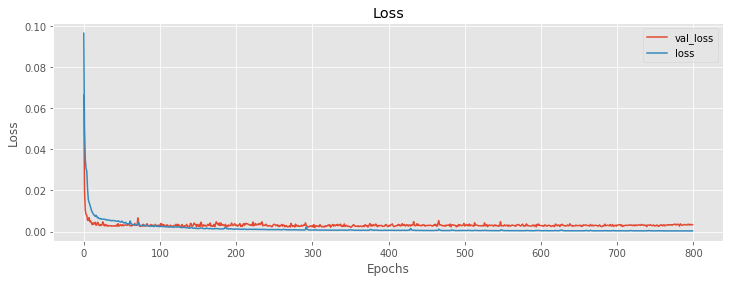

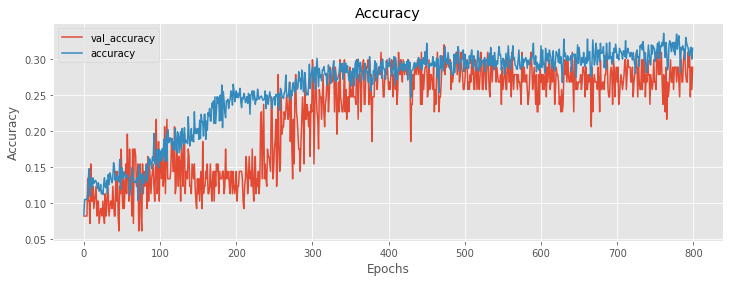

In [13]:
visualize_training_results(res)

## Visualizing the Predictions

### Validating the Model

Plotting the difference between Actual closing prices and the Predicted prices.

Predicted Prices:
 [[7685.935245944333], [7532.039484385172], [7429.756268311762], [7363.2674396940465], [7319.838054106676], [7216.06846625134], [7253.136662282388], [7257.876402945219], [7279.968840452063], [7329.766221806804]]

Actual Prices:
 [[7923.644531], [7909.7294919999995], [7911.430176], [4970.788086], [5563.707031], [5200.366211], [5392.314941], [5014.47998], [5225.629395], [5277.972168]]


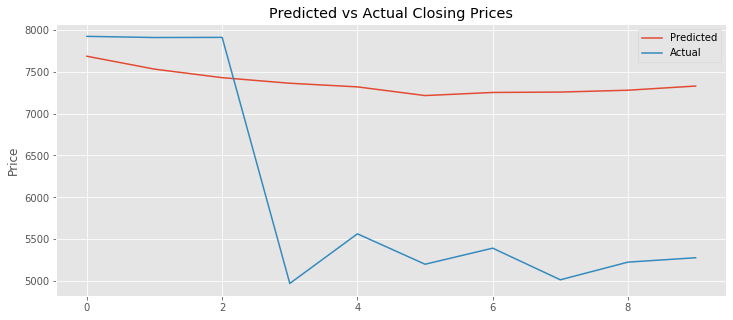

In [14]:
plt.figure(figsize=(12,5))

# Getting predictions by predicting from the last available X variable
yhat = model.predict(X[-1].reshape(1, n_per_in, n_features)).tolist()[0]

# Transforming values back to their normal prices
yhat = scaler.inverse_transform(np.array(yhat).reshape(-1,1)).tolist()

# Getting the actual values from the last available y variable which correspond to its respective X variable
actual = scaler.inverse_transform(y[-1].reshape(-1,1))

# Printing and plotting those predictions
print("Predicted Prices:\n", yhat)
plt.plot(yhat, label='Predicted')

# Printing and plotting the actual values
print("\nActual Prices:\n", actual.tolist())
plt.plot(actual.tolist(), label='Actual')

plt.title(f"Predicted vs Actual Closing Prices")
plt.ylabel("Price")
plt.legend()
plt.savefig("BTC_validation.png")
plt.show()

### Predicting/Forecasting the future prices

                  Close
2020-03-18  6121.449103
2020-03-19  6027.900350
2020-03-20  6012.703128
2020-03-21  6098.467670
2020-03-22  6127.458464
2020-03-23  5998.798563
2020-03-24  6025.435455
2020-03-25  5913.495796
2020-03-26  6052.678362
2020-03-27  6185.771986


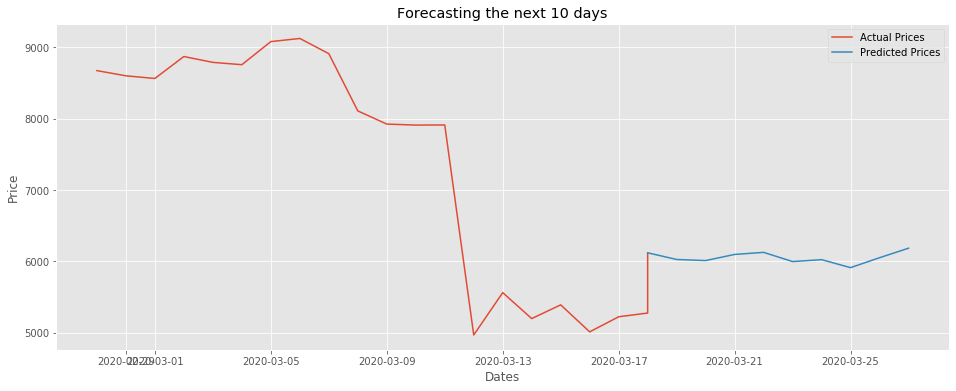

In [17]:
# Predicting off of y because it contains the most recent dates
yhat = model.predict(np.array(df.tail(n_per_in)).reshape(1, n_per_in, n_features)).tolist()[0]

# Transforming the predicted values back to their original prices
yhat = scaler.inverse_transform(np.array(yhat).reshape(-1,1)).tolist()

# Creating a DF of the predicted prices
preds = pd.DataFrame(yhat, index=pd.date_range(start=df.index[-1], periods=len(yhat), freq="D"), columns=df.columns)

# Printing the predicted prices
print(preds)

# Number of periods back to visualize the actual values
pers = 20

# Transforming the actual values to their original price
actual = pd.DataFrame(scaler.inverse_transform(df[["Close"]].tail(pers)), index=df.Close.tail(pers).index, columns=df.columns).append(preds.head(1))

# Plotting
plt.figure(figsize=(16,6))
plt.plot(actual, label="Actual Prices")
plt.plot(preds, label="Predicted Prices")
plt.ylabel("Price")
plt.xlabel("Dates")
plt.title(f"Forecasting the next {len(yhat)} days")
plt.legend()
plt.savefig("BTC_predictions.png")
plt.show()